In [1]:
%pylab inline

import os
import pandas as pd
import itertools as it
from collections import OrderedDict
from astropy.io import fits
from tools.EW import equivalent_width
from tools.Photometry import ABmag
from tools.stats import norm2one
from tools.issag import *
from scipy.ndimage import gaussian_filter
from scipy.stats import expon
from scipy.interpolate import Rbf

import seaborn as sns
from styles import slides

sns.set(style="ticks", palette="muted", color_codes=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

sdss_res = loadtxt("{}/data/SDSS_filters.txt".format(rdir))
sdss_res = [
    sdss_res[:47],
    sdss_res[47:47+89],
    sdss_res[47+89:47+89+75],
    sdss_res[47+89+75:47+89+75+89],
    sdss_res[47+89+75+89:]
]
jpas = open("{}/data/JPAS_filters.txt".format(rdir)).readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

In [3]:
%%time
# prepare SSAG run
ssag = iSSAG(size=10000)
# generate SSAG
ssag.set_all_seds(emission="both")
# extract SSPs parameters
wavelength = ssag.models.wavelength
metallicities = ssag.models.metallicities
ages = ssag.models.ages
# extract SSPs
ssps_nebular = ssag.models.ssps_nebular
ssps_stellar = ssag.models.ssps_stellar

# read SDSS data
ew_sdss = pd.read_csv("{}/data/photo-speclines.csv".format(rdir), index_col="FITS")
ew_sdss.dropna(axis="index", subset=["H_alpha", "u", "r"], inplace=True)

tools/issag.py:484: RuntimeWarning: divide by zero encountered in log10
  / 1e7 / mass_bins.sum())


CPU times: user 17min 12s, sys: 5.99 s, total: 17min 18s
Wall time: 17min 28s


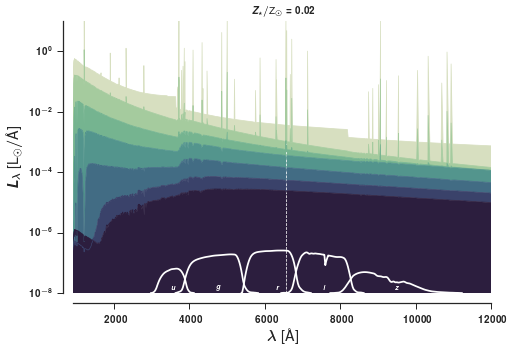

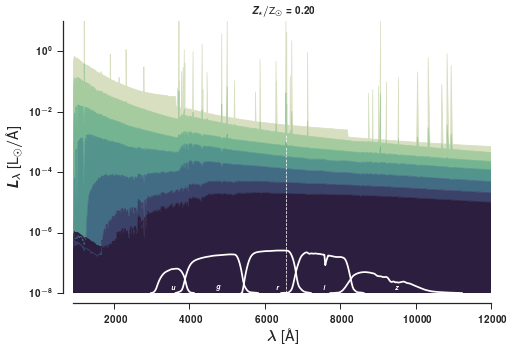

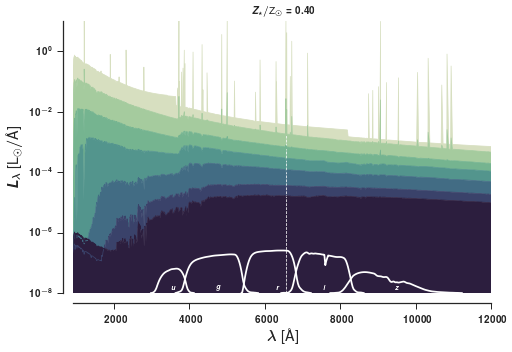

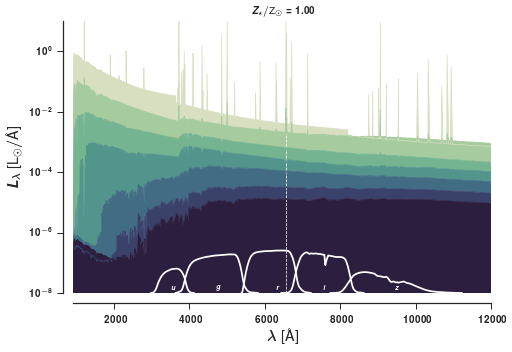

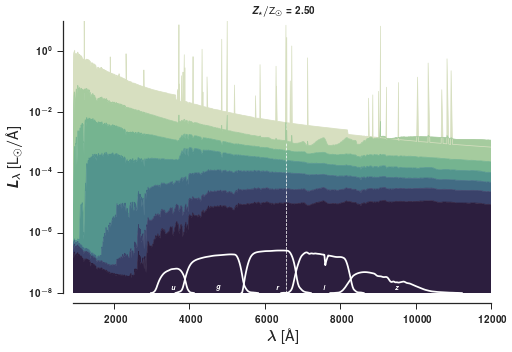

In [4]:
columns = ages[ages<=13e9][::10]#["10 Myr","50 Myr","200 Myr","1000 Myr", "13000 Myr"]
colors = sns.cubehelix_palette(columns.size, start=.5, rot=-.75)#cm.rainbow(linspace(0,1,len(columns)))

band_nms = [r"$u$",r"$g$",r"$r$",r"$i$",r"$z$"]

for k in xrange(metallicities.size):
    fig, ax = subplots(1, 1, figsize=(7.5,5))
    sns.despine(offset=10)
    ax.set_yscale("log")

    ssp_nebular = ssps_nebular[metallicities[k]]
    ssp_sel = ssp_nebular.get(columns).values
    for j in xrange(len(columns)):
        if j<len(columns)-1:
            ax.fill_between(wavelength, ssp_sel[:,j], ssp_sel[:,j+1], facecolor=colors[j], lw=0)
        else:
            ax.fill_between(wavelength, ssp_sel[:,j], 1e-35, facecolor=colors[j], lw=0)
        ax.plot(wavelength, ssp_sel[:,j], color=colors[j], lw=0.75, zorder=999)
    for i,band in enumerate(sdss_res):
        ax.plot(band[:,0], (band[:,1])/0.2e7+1e-8, color="w")
        ax.text((band[0,0]+band[-1,0])*0.5, 1.15e-8, band_nms[i], va="bottom", ha="center", color="w", size="x-small")
    ax.axvline(6562, lw=0.75, ls="--", color="w")
    ax.set_xlim(912,12000)
    ax.set_ylim(1e-8,10)
    ax.set_title(r"$Z_\star/\text{Z}_\odot=%.2f$"%(metallicities[k]), size="medium")
    ax.set_xlabel(r"$\lambda$ [\AA]", size="x-large")
    ax.set_ylabel(r"$L_\lambda$ [L$_{\odot}/$\AA]", size="x-large")

In [5]:
# First Approach to the colour-EW correlation
# In rest-frame, compute the SDSS colours & equivalent widths
ib, jb = 0, 2
ur_neb = OrderedDict()
ur_ste = OrderedDict()
ew_neb = OrderedDict()
ur_exc = OrderedDict()
for Z in metallicities:
    ssp_nebular = ssps_nebular[Z]
    ssp_stellar = ssps_stellar[Z]
    
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = [], [], []
    for j in xrange(ages.size):
        SED_neb_j = column_stack((wavelength, ssp_nebular.get(ages[j])))
        SED_ste_j = column_stack((wavelength, ssp_stellar.get(ages[j])))

        ur_neb[Z] += [ABmag(SED_neb_j, sdss_res[ib]) - ABmag(SED_neb_j, sdss_res[jb])]
        ur_ste[Z] += [ABmag(SED_ste_j, sdss_res[ib]) - ABmag(SED_ste_j, sdss_res[jb])]
        ew_neb[Z] += [equivalent_width(SED_neb_j, (6562,), (40,))[0]]
    # Compute the colour excess
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = array(ur_neb[Z]), array(ur_ste[Z]), array(ew_neb[Z])
    ur_exc[Z] = ur_ste[Z] - ur_neb[Z]

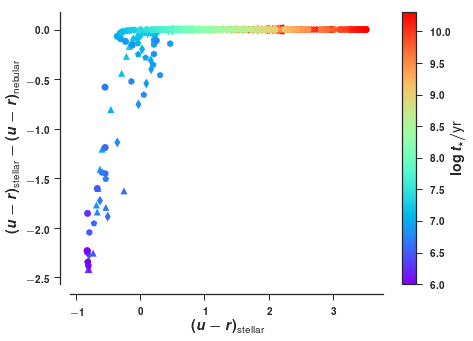

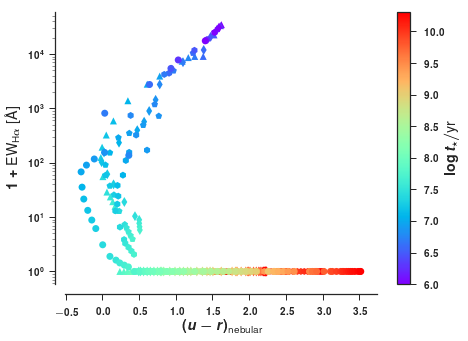

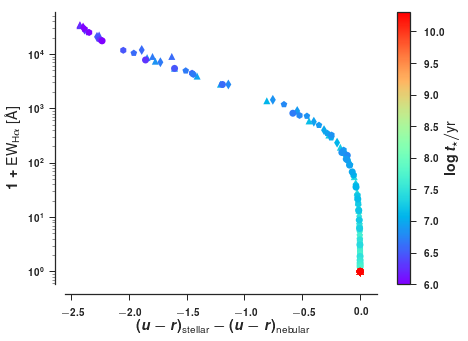

In [6]:
markers = OrderedDict(zip(metallicities,["^","d","p","h","o"]))
lb_sdss_res = "u g r i z".split()

# Plot the colour vs the colour-excess (this should show an anti-correlation)
figure(figsize=(7,5))
for Z in metallicities: scatter(ur_ste[Z], ur_exc[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
xlabel(r"$(%s-%s)_\text{stellar}$"%(lb_sdss_res[ib], lb_sdss_res[jb]), size="x-large")
ylabel(r"$(%s-%s)_\text{stellar}-(%s-%s)_\text{nebular}$"%(lb_sdss_res[ib], lb_sdss_res[jb], lb_sdss_res[ib],
                                                           lb_sdss_res[jb]), size="x-large")
cb.set_label(r"$\log{t_\star/\text{yr}}$", size="x-large")

figure(figsize=(7,5))
for Z in metallicities: scatter(ur_neb[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
gca().set_yscale("log")
xlabel(r"$(%s-%s)_\text{nebular}$"%(lb_sdss_res[ib], lb_sdss_res[jb]), size="x-large")
ylabel(r"$1+\text{EW}_{\text{H}\alpha}$ [\AA]", size="x-large")
cb.set_label(r"$\log{t_\star/\text{yr}}$", size="x-large")

figure(figsize=(7,5))
for Z in metallicities: scatter(ur_exc[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
gca().set_yscale("log")
xlabel(r"$(%s-%s)_\text{stellar}-(%s-%s)_\text{nebular}$"%(lb_sdss_res[ib], lb_sdss_res[jb],
                                                           lb_sdss_res[ib], lb_sdss_res[jb]),
       size="x-large")
ylabel(r"$1+\text{EW}_{\text{H}\alpha}$ [\AA]", size="x-large")
cb.set_label(r"$\log{t_\star/\text{yr}}$", size="x-large")

# This will help separate the age-nebular emission relation

In [7]:
# compute colours

ur_neb, ur_ste, ew_neb = [], [], []
for j in xrange(ssag.sample.index.size):
    reds = ssag.sample.redshift[j]
    SED_neb_j = column_stack((wavelength, ssag.seds_nebular.iloc[:,j]))
    SED_ste_j = column_stack((wavelength, ssag.seds_stellar.iloc[:,j]))

    ur_neb += [ABmag(SED_neb_j, sdss_res[ib]) - ABmag(SED_neb_j, sdss_res[jb])]
    ur_ste += [ABmag(SED_ste_j, sdss_res[ib]) - ABmag(SED_ste_j, sdss_res[jb])]
    ew_neb += [equivalent_width(SED_neb_j, (6562,), (40,))[0]]
# Compute the colour excess
ur_neb, ur_ste, ew_neb = array(ur_neb), array(ur_ste), array(ew_neb)
ur_exc = ur_ste - ur_neb

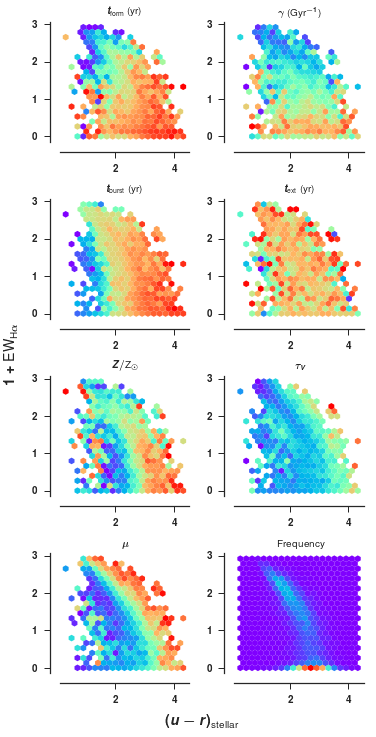

In [8]:
x, y = ur_ste, log10(1+ew_neb)
mask = ones(ew_neb.size, dtype=np.bool) #(ew_neb > 0.0) #& (ur_ste <= 2.22)

zs = (
    log10(ssag.sample.t_form),
    ssag.sample.gamma,
    log10(ssag.sample.t_burst),
    log10(ssag.sample.t_ext),
    ssag.sample.metallicity,
    ssag.sample.tau_v,
    ssag.sample.mu_v,
    ssag.sample.a_burst
)

labels = (
    r"$t_\text{form}$ (yr)",
    r"$\gamma$ (Gyr$^{-1}$)",
    r"$t_\text{burst}$ (yr)",
    r"$t_\text{ext}$ (yr)",
    r"$Z/\text{Z}_\odot$",
    r"$\tau_V$",
    r"$\mu$",
    r"Frequency"
)

fig, axs = subplots(4, 2, figsize=(5, 10), sharex=True, sharey=True)
axs = axs.ravel()
sns.despine(offset=10)

for i in xrange(axs.size):
    if i < axs.size-1:
        axs[i].hexbin(x[mask], y[mask], zs[i][mask], 20, mincnt=0, edgecolors=None, reduce_C_function=median, cmap=cm.rainbow)
#         axs[i].scatter(x, y, c=zs[i], s=4, lw=0, cmap=cm.rainbow)
    else:
        axs[i].hexbin(x[mask], y[mask], gridsize=20, mincnt=0, edgecolors=None, cmap=cm.rainbow)
    axs[i].set_title(labels[i], size="medium")
    
fig.text(0.5, 0.0, r"$(%s-%s)_\text{stellar}$"%(lb_sdss_res[ib], lb_sdss_res[jb]), size="x-large", ha="center", va="top")
fig.text(0.0, 0.5, r"$1+\text{EW}_{\text{H}\alpha}$", size="x-large", ha="right", va="center", rotation="vertical")
fig.tight_layout()
# fig.savefig("img/photometric-ew.pdf", bbox_inches="tight")

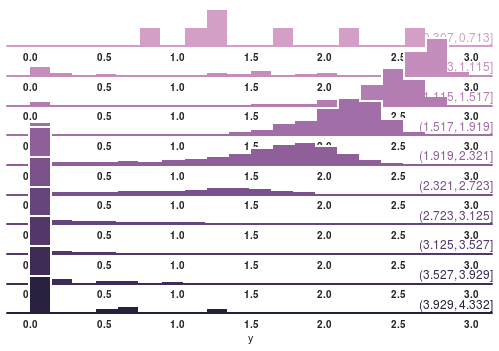

In [9]:
x, y = ur_ste[ew_neb>0], log10(1+ew_neb[ew_neb>0])

x_binned = pd.cut(x, 10)
sr = pd.Series(y)
gr = sr.groupby(x_binned)
# print gr.count()
sg = pd.DataFrame()
for name in sorted(gr.groups):
    sg = sg.append(pd.DataFrame({"bin": name, "y": gr.get_group(name)}), ignore_index=True)

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=.25, light=.7)
g = sns.FacetGrid(sg, row="bin", hue="bin", aspect=15, size=.5, palette=pal, sharey=False)

# g.map(sns.kdeplot, "y", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
# g.map(sns.kdeplot, "y", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.hist, "y", bins=20, range=(0, 3), histtype="stepfilled", lw=1.5)
g.map(plt.hist, "y", bins=20, range=(0, 3), histtype="step", color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1.0, 0.2, label, fontweight="bold", color=color, 
            ha="right", va="center", transform=ax.transAxes)

g.map(label, "y")
# for ax in g.axes.ravel()[:-1]: ax.set_xticks([])

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [10]:
# x, y = ur_ste, ew_neb
# xi, yi = meshgrid(linspace(x.min(),x.max(),20), linspace(y.min(),y.max(),20), indexing="xy")

# zs = (
#     log10(ssag.sample.t_form),
#     ssag.sample.gamma,
#     log10(ssag.sample.t_burst),
#     log10(ssag.sample.t_ext),
#     ssag.sample.metallicity,
#     ssag.sample.tau_v,
#     ssag.sample.mu_v,
#     ssag.sample.redshift
# )

# labels = (
#     r"$t_\text{form}$ (yr)",
#     r"$\gamma$ (Gyr$^{-1}$)",
#     r"$t_\text{burst}$ (yr)",
#     r"$t_\text{ext}$ (yr)",
#     r"$Z/\text{Z}_\odot$",
#     r"$\tau_V$",
#     r"$\mu$",
#     r"$z$"
# )

# fig, axs = subplots(4, 2, figsize=(5, 10), sharex=True, sharey=True)
# axs = axs.ravel()
# sns.despine(offset=10)

# for i in xrange(axs.size):
#     mask = ~isnan(zs[i])
#     interp = Rbf(x[mask], y[mask], zs[i][mask], function="linear")
#     zi = interp(xi, yi)
#     dy, dx = np.gradient(zi)
    
# #     x_binned, x_bins = pd.cut(x, 10, retbins=True)
# #     x_cent = (x_bins[1:] + x_bins[:-1])*0.5
# #     y_medi = pd.Series(y).groupby(x_binned).median().values
# #     start_at = column_stack((x_cent, y_medi))
    
#     axs[i].streamplot(xi, yi, dx, dy, color=zi, density=0.5, linewidth=1.0, arrowsize=0.7, cmap=cm.rainbow)
#     axs[i].set_title(labels[i], size="medium")

# fig.text(0.5, 0.0, r"$(%s-%s)_\text{stellar}$"%(lb_sdss_res[ib], lb_sdss_res[jb]), size="x-large", ha="center", va="top")
# fig.text(0.0, 0.5, r"$\text{EW}_{\text{H}\alpha}$", size="x-large", ha="right", va="center", rotation="vertical")
# fig.tight_layout()